In [1]:
# !pip install matplotlib pandas

In [1]:
from typing import List, Dict, Tuple

import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

__WORKING_BRANCH_PATH = (
    "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch"
)

hatch = {
    'Vector': '',
    'Skiplist': '\\\\\\\\\\\\',
    'Hashskiplist': '//',
    'Hashlinklist': '----'
}

linestyle = {
    'Vector': '-',
    'Skiplist': '-',
    'Hashskiplist': '-.',
    'Hashlinklist': '..'
}

alpha = {
    'Vector': 1,
    'Skiplist': 0.8,
    'Hashskiplist': 1,
    'Hashlinklist': 1,
}

color = {
    'Vector': 'darkslateblue',
    'Skiplist': 'slategray',
    'Hashskiplist': 'darkkhaki',
    'Hashlinklist': 'chocolate'
    # 'Vector': 'black',
    # 'Skiplist': 'black',
    # 'Hashskiplist': 'black',
    # 'Hashlinklist': 'black'
}

linewidth = {
    'Vector': 1,
    'Skiplist': 1,
    'Hashskiplist': 1,
    'Hashlinklist': 1,
}

edgecolor = {
    'Vector': 'black',
    'Skiplist': 'black',
    'Hashskiplist': 'black',
    'Hashlinklist': 'black'
}

label = {
    'Vector': 'vector',
    'Skiplist': 'skiplist',
    'Hashskiplist': 'hash skiplist',
    'Hashlinklist': 'hash linklist'
}

plt.rcParams["font.family"] = "serif"

alphabets = "abcdefghijklmnopqrstuvwxyz"

In [2]:
def get_properties(key: str) -> Dict[str, str]:
    if key.capitalize() in label:
        return {
            # "label": label.get(key.capitalize()),
            "color": color.get(key.capitalize()) or "None",
            # "edgecolor": edgecolor.get(key.capitalize()) or "None",
            # "linestyle": linestyle.get(key.capitalize()),
            # "hatch": hatch.get(key.capitalize()),
            "alpha": alpha.get(key.capitalize()),
        }
    else:
        raise ValueError(f"Unknown key: {key}")

In [3]:
def get_exp_dirname(query_type: str, selectivity: float, entry_size: int) -> str:
    return (
        f"{__WORKING_BRANCH_PATH}/experiments-{query_type}-{selectivity}-{entry_size}"
    )


def get_log_dirname(
    query_type: str,
    inserts: int,
    point_queries: int,
    range_queries: int,
    selectivity: float,
    memtable: str,
    entry_size: int,
    number_of_entries_per_page: int,
    number_of_pages: int,
    prefixlen: int = 0,
    bucket_count: int = 0,
    size_ratio: int = 4,
    updates: int = 0,
):
    if memtable.lower() in ("hashskiplist", "hashlinklist"):
        return f"{get_exp_dirname(query_type, selectivity, entry_size)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio} l {prefixlen} bucket_count {bucket_count}"
    return f"{get_exp_dirname(query_type, selectivity, entry_size)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio}"

In [4]:
def process_log_file(
    log_file: str, logs_dict: dict, index, key: str = "", key_to_search: str = ""
):
    with open(log_file + "/workload.log", "r") as ff:
        for line in ff.readlines():
            if line.startswith(key_to_search):
                temp_line = line.strip(key_to_search)
                logs_dict[key] = int(temp_line.split(" ")[index])
                break

def compact_formatter(x, pos):
    if x >= 1e6:  # For millions
        return f'{x/1e6:.0f}M'
    elif x >= 1e3:  # For thousands
        return f'{x/1e3:.0f}K'
    else:
        return str(x)

In [5]:
def prepare_dataframe(log_file_path: str, key: str="RangeQueryTime: ") -> pd.DataFrame:
    ff = open(log_file_path, "r")
    range_quereis = []

    for line in ff.readlines():
        if key in line:
            range_quereis.append(float(line.split(" ")[1]))
    
    return pd.DataFrame(range_quereis, columns=["TimeTaken"])

In [6]:
query_type = "PQ"
entry_size = 64
memtables = ["Vector", "SkipList", "HashSkipList", "HashLinkList"]
inserts = 140000
point_queries = 200
range_queries = 0
number_of_entries_per_page = 64
number_of_pages = 4096
updates = 0
prefixlen = 6
bucket_count = 100000

selectivities = [0]
list_vec_df = []
list_skip_df = []
titles = []

for selectivity in selectivities:
    vec_logdir = get_log_dirname(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[0],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    skip_logdir = get_log_dirname(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[1],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    hash_skip_logdir = get_log_dirname(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[2],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    hash_link_logdir = get_log_dirname(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[3],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    vec_df = prepare_dataframe(vec_logdir+"/workload.log", "PointQueryTime: ")
    skip_df = prepare_dataframe(skip_logdir+"/workload.log", "PointQueryTime: ")
    hash_skip_df_6_100000 = prepare_dataframe(hash_skip_logdir+"/workload.log", "PointQueryTime: ")
    hash_link_df_6_100000 = prepare_dataframe(hash_link_logdir+"/workload.log", "PointQueryTime: ")
    hash_skip_df_0_100000 = prepare_dataframe(
        get_log_dirname(
            query_type,
            inserts,
            point_queries,
            range_queries,
            selectivity,
            memtables[2],
            entry_size,
            number_of_entries_per_page,
            number_of_pages,
            0,
            bucket_count,
        )+"/workload.log",
        "PointQueryTime: "
    )
    hash_skip_df_10_1 = prepare_dataframe(
        get_log_dirname(
            query_type,
            inserts,
            point_queries,
            range_queries,
            selectivity,
            memtables[2],
            entry_size,
            number_of_entries_per_page,
            number_of_pages,
            10,
            1,
        )+"/workload.log",
        "PointQueryTime: "
    )

    hash_skip_df_2_10000 = prepare_dataframe(
        get_log_dirname(
            query_type,
            inserts,
            point_queries,
            range_queries,
            selectivity,
            memtables[2],
            entry_size,
            number_of_entries_per_page,
            number_of_pages,
            2,
            10000,
        )+"/workload.log",
        "PointQueryTime: "
    )
    

FileNotFoundError: [Errno 2] No such file or directory: '/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-0-64/I 140000 U 0 S 0 Y 0 Q 200 m vector E 64 B 64 P 4096 T 4/workload.log'

NameError: name 'skip_df' is not defined

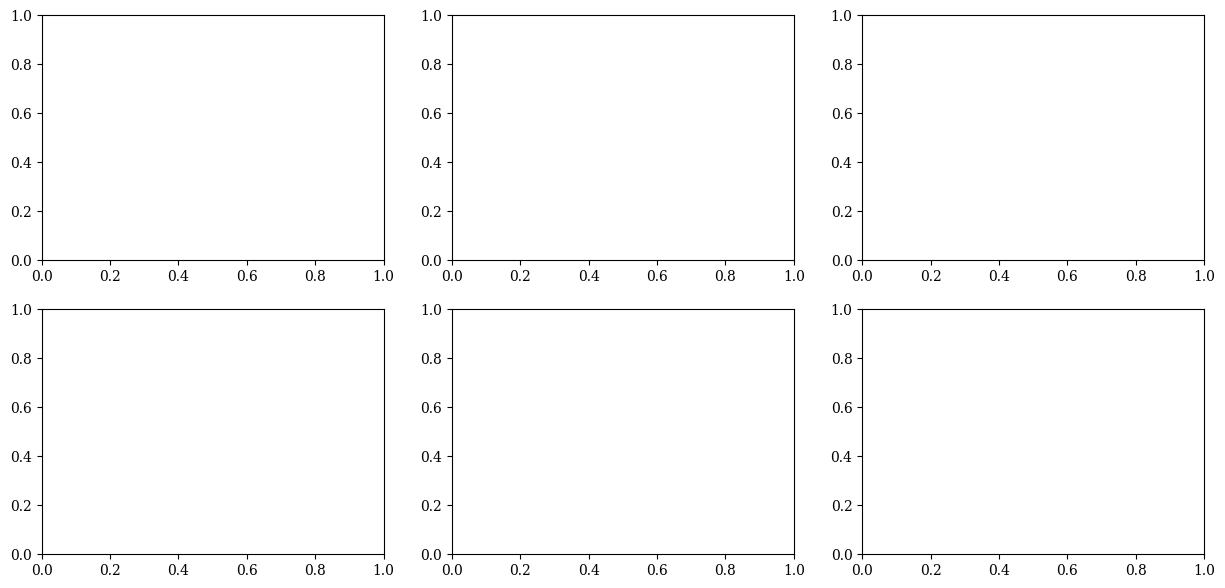

In [7]:
plt.rcParams["font.family"] = "serif"

num = 200

FIGSIZE = (18, 7)
fig, ax = plt.subplots(2, 3, figsize=FIGSIZE)
ax[0,0].plot(skip_df.index[:num], skip_df['TimeTaken'][:num] /(1000), label='skip-list', **get_properties("Skiplist"))
ax[0,0].plot(vec_df.index[:num], vec_df['TimeTaken'][:num]/(1000), label='vector', **get_properties("Vector"))

# ax[0,0].set_title("vector vs skip-list", fontsize=12)
ax[0,0].set_xlabel('point query number', fontsize=12)
ax[0,0].set_ylabel('latency (ms)', fontsize=12)
ax[0,0].set_ylim(bottom=0)
ax[0,0].legend(loc="upper right", fontsize=12)
ax[0,0].annotate(f"avg. time", xy=(0,60), fontsize=12)
ax[0,0].annotate(f"vector: {(vec_df[:num] / 1000).mean()['TimeTaken']:.3f} $\mathit{{ms}}$", xy=(0,55), fontsize=12)
ax[0,0].annotate(f"skip-list: {(skip_df[:num] / 1000).mean()['TimeTaken']:.3f} $\mathit{{ms}}$", xy=(0,50), fontsize=12)
ax[0,0].text(-27, 65, '(a)', fontsize=12, ha='center', fontweight='bold')

# =================================================================================

ax[0,1].plot(skip_df.index[:num], skip_df['TimeTaken'][:num], label='skip-list', **get_properties("Skiplist"))
ax[0,1].plot(hash_skip_df_6_100000.index[:num], hash_skip_df_6_100000['TimeTaken'][:num], label='hash skip-list X=6, H=100K', **get_properties("Hashskiplist"))

# ax[0,1].set_title("skip-list vs hash skip-list", fontsize=12)
ax[0,1].set_xlabel(f'point query number', fontsize=12)
ax[0,1].set_ylabel('latency ($\mu$s)', fontsize=12)
ax[0,1].set_ylim(bottom=0, top=7)
ax[0,1].legend(loc="upper right", fontsize=12)
ax[0,1].annotate(f"avg. time", xy=(0,6.5), fontsize=12)
ax[0,1].annotate(f"hash skip-list: {hash_skip_df_6_100000[:num].mean()['TimeTaken']:.2f} $\mathit{{\mu}}s$", xy=(0,5.9), fontsize=12)
ax[0,1].annotate(f"skip-list: {skip_df[:num].mean()['TimeTaken']:.2f} $\mathit{{\mu}}s$", xy=(0,5.4), fontsize=12)
ax[0,1].text(-25, 7, '(b)', fontsize=12, ha='center', fontweight='bold')

# =================================================================================

ax[0,2].plot(skip_df.index[:num], skip_df['TimeTaken'][:num], label='skip-list', **get_properties("Skiplist"))
ax[0,2].plot(hash_link_df_6_100000.index[:num], hash_link_df_6_100000['TimeTaken'][:num], label='hash linked-list X=6, H=100K', **get_properties("Hashlinklist"))

# ax[0,2].set_title("skip-list vs hash linked-list", fontsize=12)
ax[0,2].set_xlabel('point query number', fontsize=12)
ax[0,2].set_ylabel('latency ($\mu$s)', fontsize=12)
ax[0,2].set_ylim(bottom=0, top=7)
ax[0,2].legend(loc="upper right", fontsize=12)
ax[0,2].annotate(f"avg. time", xy=(0,6.5), fontsize=12)
ax[0,2].annotate(f"hash link-list: {hash_link_df_6_100000[:num].mean()['TimeTaken']:.2f} $\mathit{{\mu}}s$", xy=(0,5.9), fontsize=12)
ax[0,2].annotate(f"skip-list: {skip_df[:num].mean()['TimeTaken']:.2f} $\mathit{{\mu}}s$", xy=(0,5.4), fontsize=12)
ax[0,2].text(-25, 7, '(c)', fontsize=12, ha='center', fontweight='bold')

# =================================================================================

ax[1,0].plot(skip_df.index[:num], skip_df['TimeTaken'][:num], label='skip-list', **get_properties("Skiplist"))
ax[1,0].plot(hash_skip_df_0_100000.index[:num], hash_skip_df_0_100000['TimeTaken'][:num], label='hash skip-list X=0, H=100K', **get_properties("Hashskiplist"))

# ax[1,0].set_title("skip-list vs hash skip-list", fontsize=12)
ax[1,0].set_xlabel('point query number', fontsize=12)
ax[1,0].set_ylabel('latency ($\mu$s)', fontsize=12)
ax[1,0].set_ylim(bottom=0, top=120)
ax[1,0].legend(loc="upper right", fontsize=12)
ax[1,0].annotate(f"avg. time", xy=(0,108), fontsize=12)
ax[1,0].annotate(f"hash skip-list: {(hash_skip_df_0_100000[:num]).mean()['TimeTaken']:.3f} $\mathit{{\mu}}s$", xy=(0,99), fontsize=12)
ax[1,0].annotate(f"skip-list: {(skip_df[:num]).mean()['TimeTaken']:.3f} $\mathit{{\mu}}s$", xy=(0,91), fontsize=12)
ax[1,0].text(-32, 120, '(d)', fontsize=12, ha='center', fontweight='bold')

# =================================================================================

ax[1,1].plot(skip_df.index[:num], skip_df['TimeTaken'][:num], label='skip-list', **get_properties("Skiplist"))
ax[1,1].plot(hash_skip_df_10_1.index[:num], hash_skip_df_10_1['TimeTaken'][:num], label='hash skip-list X=10, H=1', **get_properties("Hashskiplist"))

# ax[1,1].set_title("skip-list vs hash skip-list", fontsize=12)
ax[1,1].set_xlabel(f'point query number', fontsize=12)
ax[1,1].set_ylabel('latency ($\mu$s)', fontsize=12)
ax[1,1].set_ylim(bottom=0, top=120)
ax[1,1].legend(loc="upper right", fontsize=12)
ax[1,1].annotate(f"avg. time", xy=(0,108), fontsize=12)
ax[1,1].annotate(f"hash skip-list: {(hash_skip_df_10_1[:num]).mean()['TimeTaken']:.3f} $\mathit{{\mu}}s$", xy=(0,99), fontsize=12)
ax[1,1].annotate(f"skip-list: {(skip_df[:num]).mean()['TimeTaken']:.3f} $\mathit{{\mu}}s$", xy=(0,91), fontsize=12)
ax[1,1].text(-32, 120, '(e)', fontsize=12, ha='center', fontweight='bold')

# =================================================================================

ax[1,2].plot(skip_df.index[:num], skip_df['TimeTaken'][:num], label='skip-list', **get_properties("Skiplist"))
ax[1,2].plot(hash_skip_df_2_10000.index[:num], hash_skip_df_2_10000['TimeTaken'][:num], label='hash skip-list X=2, H=10K', **get_properties("Hashskiplist"))

# ax[1,2].set_title("skip-list vs hash skip-list", fontsize=12)
ax[1,2].set_xlabel('point query number', fontsize=12)
ax[1,2].set_ylabel('latency ($\mu$s)', fontsize=12)
ax[1,2].set_ylim(bottom=0)
ax[1,2].legend(loc="upper right", fontsize=12)
ax[1,2].annotate(f"avg. time", xy=(0,7.5), fontsize=12)
ax[1,2].annotate(f"hash link-list: {hash_skip_df_2_10000[:num].mean()['TimeTaken']:.2f} $\mathit{{\mu}}s$", xy=(0,6.9), fontsize=12)
ax[1,2].annotate(f"skip-list: {skip_df[:num].mean()['TimeTaken']:.2f} $\mathit{{\mu}}s$", xy=(0,6.3), fontsize=12)
ax[1,2].text(-25, 8, '(f)', fontsize=12, ha='center', fontweight='bold')
# ax[1,2].plot(hash_skip_df_10_1.index[:num], hash_skip_df_10_1['TimeTaken'][:num], alpha=0.8, color='darkred', label='hash skip List l 10 bck 1')

plt.tight_layout()
plt.savefig("point-queries.eps", format="eps", bbox_inches="tight", dpi=1200)